# Hyperparameter Tuning with Reinforcement Learning
## Using Proximal Policy Optimization to Find Regularization Values

- Jesse Galef 2019

When we have a dataset with many features, fitting a model without *over*fitting can be difficult, and likely requires regularization. 

We're going to take the Boston Housing dataset (which has about 500 sample) and take the third-order polynomial features -- meaning we have 559 features. Ordinary Least Squares doesn't handle this well, so we want to find a good way to apply regularization.

Choosing the correct hyperparameters can be done a few ways:

    1. Intuition/Experience/Default Values

    2. Gridsearch across possible combinations of values

    3. Random Search

    4. Reinforcement Learning Random Search
    
This project is going to use option 4, applying the Proximal Policy Optimization reinforcement learning algorithm to try different values and adapt our search distributions depending on how the values perform.

It may be overkill for a problem like this -- we're only adjusting two hyperparameters and it's likely a smooth surface -- but it should be a fun way to demonstrate the principle.


## Import our data and typical packages/libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [177]:
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

### Prepare our Complex-ified Boston Housing Data

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [513]:
np.random.seed(0)

from sklearn.datasets import load_boston

data = load_boston()

X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=1./6)

# ***********************************************
# Apply scaling and take the polynomial features
# only basing our scaling values on training data

ss = StandardScaler().fit(X_train)
poly = PolynomialFeatures(3, include_bias=False).fit(X_train)

X_train = poly.transform(ss.transform(X_train))
X_test = poly.transform(ss.transform(X_test))

print ("Training Data Shape:", X_train.shape)
print ("Testing Data Shape:", X_test.shape)



Training Data Shape: (421, 559)
Testing Data Shape: (85, 559)


### Let's see how models with default parameters do:

In [514]:
print ("Linear Regression R^2: {:.3f}".format(cross_val_score(LinearRegression(), X_train, y_train, cv=10).mean()))
print ("(OLS has trouble when there are more features than samples, I believe)\n")
print ("Default Lasso R^2: {:.3f}".format(cross_val_score(Lasso(), X_train, y_train, cv=10).mean()))
print ("Default Ridge R^2: {:.3f}".format(cross_val_score(Ridge(), X_train, y_train, cv=10).mean()))

print ("Default Elastic Net R^2: {:.3f}".format(cross_val_score(ElasticNet(), X_train, y_train, cv=10).mean()))

Linear Regression R^2: -182.085
(OLS has trouble when there are more features than samples, I believe)

Default Lasso R^2: 0.699
Default Ridge R^2: 0.694
Default Elastic Net R^2: 0.749


### Now let's try some of the Out-of-the-box Cross-Validated regularization finders

In [287]:
lcv = LassoCV(cv=10).fit(X_train, y_train)
print ('LassoCV R^2: {:.3f}'.format(cross_val_score(Lasso(alpha=lcv.alpha_), X_train, y_train, cv=10).mean()))
rcv = RidgeCV(alphas=[.01,.03,.1,.3,1,3,10,30,100,300,1000]).fit(X_train, y_train)
print ('RidgeCV R^2: {:.3f}'.format(cross_val_score(Ridge(alpha=rcv.alpha_), X_train, y_train, cv=10).mean()))


LassoCV R^2: 0.771
RidgeCV R^2: 0.795


# Goal: See if we can find regularization hyperparameters that beat these when tested on the held-out test data

# Modeling

The ElasticNet model requires two hyperparameters for regularization, l1_ratio and alpha.

1. Start with some method of picking random combinations of l1_ratio & alpha

2. Sample a few combinations

3. Test each combination of l1_ratio / alpha

4. Adjust our random-sampling method to make it more likely to draw better combinations in the future

5. Go back to 2

----

- l1_ratio $\in (0,1)$ : Amount of the regularization which is L1, (1-alpha) is L2
- alpha $\in (0,\infty)$ : The total regularization penalty


L1_ratio can be between 0 and 1, so we'll use a Beta distribution.

Alpha can be any real value over 0, so we'll draw it from a Gamma distribution.

Our neural net needs to learn and improve the parameters that defines these two distributions.
- l1_ratio ~ Beta(a,b)
- alpha ~ Gamma(c,d)



In [179]:
import tensorflow_probability as tfp

In [185]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
import keras.backend as K



In [288]:
def ppo_loss(a, b, c, d, old_ratio, old_alpha,
             old_logp_ratio, old_logp_alpha,
             advantage, epsilon=.2):
    # https://spinningup.openai.com/en/latest/algorithms/ppo.html
    
    def custom_loss(y_true, y_pred):
        """
        note: y_true and y_pred are not used!
            This feels like a hackish way to write the ppo loss function,
            and there are better implementations. Technically, this isn't
            a loss function, it's just a way of creating an optimizer.
        
        This adjusts the model's distribution-defining outputs a, b, c and d
        
        If the advantage score for a sample is positive, the model
        adjusts its weights so that its combination of alpha/ratio
        are more likely to be chosen. 
        
        """ 
        
        new_ratio_distribution = tfp.distributions.Beta(a, b)
        new_logp_ratio = new_ratio_distribution.log_prob(old_ratio)
        
        new_alpha_distribution = tfp.distributions.Gamma(c,d)
        new_logp_alpha = new_alpha_distribution.log_prob(old_alpha)
        
        ratio = (old_logp_ratio + old_logp_alpha) - (new_logp_ratio + new_logp_alpha)
        
        clipped_ratio = K.clip(ratio, min_value=1-epsilon, max_value=1+epsilon)
        minimum = K.minimum(ratio * advantage, clipped_ratio * advantage)
        
        return K.mean(minimum)
    return custom_loss

def dummy_loss(y_true, y_pred):
    return K.constant(0.)


In [190]:

# from keras.initializers import Constant

def get_new_model(epsilon=.2):
    dummy_input = Input([1], name='dummy_input')
    activity = dummy_input
    activity = Dense(4, activation='relu')(activity)
    activity = Dense(4, activation='relu')(activity)
    activity = Dense(4, activation='relu')(activity)

    # ****************************************
    # Get the parameters for the distributions
    # ****************************************
    
    a = Dense(1, activation='softplus', bias_initializer='ones')(activity)
    b = Dense(1, activation='softplus', bias_initializer='ones')(activity)

    c = Dense(1, activation='softplus', bias_initializer='ones')(activity)
    d = Dense(1, activation='softplus', bias_initializer='ones')(activity)
    
    # In theory, the softplus activation should never be zero
    # but rounding might cause problems. Let's add epsilon to be safe:
    a = Lambda(lambda x: x + K.epsilon(), name='a')(a)
    b = Lambda(lambda x: x + K.epsilon(), name='b')(b)

    c = Lambda(lambda x: x + K.epsilon(), name='c')(c)
    d = Lambda(lambda x: x + K.epsilon(), name='d')(d)
        
    # ************************************************
    # Create the distributions, sample the values,
    # and calculate the log probability of this sample
    # ************************************************
        
    ratio_distribution = tfp.distributions.Beta(a, b, name='ratio_beta_distribution')
    alpha_distribution = tfp.distributions.Gamma(c, d, name='alpha_gamma_distribution')

    ratio = Lambda(lambda x: K.clip(ratio_distribution.sample(), K.epsilon(),1.- K.epsilon()), 
                            name='ratio')(dummy_input)
    alpha = Lambda(lambda x: alpha_distribution.sample(),
                            name='alpha')(dummy_input)
    
    logp_ratio = Lambda(lambda x: ratio_distribution.log_prob(x), name='logp_ratio')(ratio)
    logp_alpha = Lambda(lambda x: alpha_distribution.log_prob(x), name='logp_alpha')(alpha)
    
    # *******************************************************
    # Create the additional inputs to be used in the ppo loss
    # These old logp values are compared to the new
    # *******************************************************
    
    old_ratio = Input([1], name='old_ratio')
    old_alpha = Input([1], name='old_alpha')
    
    old_logp_ratio = Input([1], name='old_logp_ratio')
    old_logp_alpha = Input([1], name='old_logp_alpha')

    advantage = Input([1], name='advantage')
    
    # ****************************************
    # Compile!
    # ****************************************
    
    model = Model(inputs=[dummy_input, 
                          old_ratio, old_alpha,
                          old_logp_ratio, old_logp_alpha,
                          advantage], 
                 outputs=[a, b, c, d,
                         ratio, alpha,
                          logp_ratio, logp_alpha])
        
    # Because I'm doing this with Keras' standard tools, it 
    # expects to apply a loss function to every output.
    # We're not really applying a loss function based on each
    # output, we want a single adjustment based on all outputs.
    # Hence the single ppo_loss call and 7 dummy_loss calls
    model.compile('adam', [ppo_loss(a, b, c, d,
                                   old_ratio, old_alpha,
                                   old_logp_ratio, old_logp_alpha,
                                   advantage, epsilon=epsilon),
                          dummy_loss, dummy_loss, dummy_loss, dummy_loss,
                          dummy_loss, dummy_loss, dummy_loss])
    
    return model



In [191]:
def sample_model(model):
    """
    Using dummy input, samples:
    ratio from the Beta distribution defined by (a, b)
    alpha from the Gamma distribution defined by (c, d)
    returns:
        a, b, c, d, ratio, alpha, logp_ratio, logp_alpha
        
    Because we are getting sample values from the distributions
    rather than training the weights, the inputs are unimportant
    with the exception of the first dummy input -- which is 
    expected to be 1's
    
    """
    
    x = np.array([[1]])
    outputs = model.predict([x,x,x,x,x,x])
    outputs = [var[0][0] for var in outputs]
    
    return {name: val for name, val in zip(model.output_names, outputs)}


### Check that the model is making sense -- what values do we get when we sample?

In [289]:
model = get_new_model()
sample_model(model)

{'a': 1.3037093,
 'b': 1.2986715,
 'c': 1.2852283,
 'd': 1.3396466,
 'ratio': 0.7155834,
 'alpha': 0.15583071,
 'logp_ratio': 0.09878224,
 'logp_alpha': -0.25763375}

# Write the iterative training procedure

In [195]:

def test_vars(alpha, ratio, X, y):
    """
    Gets the performance of an ElasticNet using the passed
    parameters for alpha and l1_ratio
    """
    reg = ElasticNet(alpha=alpha, l1_ratio=ratio, max_iter=10000, tol=.001, selection='random')
    scores = cross_val_score(reg, X, y, cv=5)
    # I'm clipping twice in the process -- here, to prevent extreme negative
    # scores from affecting the batchs' mean scores, and again later in 
    # calculating the advantage.
    
    return np.clip(scores.mean(),-1,1)


In [196]:
def get_next_trials(model, X, y, batch=8):
    """
    Samples from our model [batch] times, 
    Returning a dataframe of:
        The parameters that define the distributions (a, b, c, d)
        The alpha and ratio values sampled from these distributions
        The log probabilities of sampling those values
        The cross-validated performance of an ElasticNet trained with 
            those alpha and l1_ratio hyperparameters
    
    """
    trials = []
    for i in range(batch):
        result = sample_model(model)
        result['score'] = test_vars(result['alpha'], result['ratio'], X, y)
        trials.append(result)
    trials = pd.DataFrame(trials)
    trials['advantage'] = (trials.score - trials.score.median()) / trials.score.std()
    return trials

In [197]:
def train_model(model, trials, batch=16, epochs=4, resample=False):
    """
    Iteratively samples hyperparameters from the model and tests their performance,
    then trains the model based on the batch of results.
    
    trials: a pandas dataframe containing an ongoing record of the sampling and performance
    resample: if False, will train only on the most recent batch.  If True, will 
        use [batch] random results from previous versions in its training
    """
    
    idx = list(range(len(trials)-batch, len(trials)))
    
    if resample is True:
        if len(trials) >= batch * 2:
            idx = np.concatenate([idx, np.random.choice(range(len(trials)), batch)])

    this_batch = trials.loc[idx]
    dummy_inputs = np.ones([len(idx), 1])

    ratios = this_batch['ratio'].values[..., np.newaxis]
    alphas = this_batch['alpha'].values[..., np.newaxis]
    advantages = this_batch['advantage'].values[..., np.newaxis]
    logp_ratios = this_batch['logp_ratio'].values[..., np.newaxis]
    logp_alpha = this_batch['logp_alpha'].values[..., np.newaxis]

    a_batch = this_batch['a'].values[..., np.newaxis]
    b_batch = this_batch['b'].values[..., np.newaxis]
    c_batch = this_batch['c'].values[..., np.newaxis]
    d_batch = this_batch['d'].values[..., np.newaxis]


    # During training, we're using the input to adjust the model's
    # weights -- the output of these fitting process is unimportant
    inputs = [dummy_inputs,
             ratios, alphas,
             logp_ratios, logp_alpha,
             advantages]

    outputs = [a_batch, b_batch, c_batch, d_batch,
              dummy_inputs, dummy_inputs, dummy_inputs, dummy_inputs]
    
    model.fit(inputs, outputs, epochs=epochs, verbose=0)



## Train the model! 
- 100 Batches
- 16 Samples per batch
- Each batch trained for 16 epochs
- Epsilon of .5 -- the probability of sampling a particular set of hyperparameters does not change by more than a factor of .5 each training epoch

In [199]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [ ]:
np.random.seed(0)
model = get_new_model(epsilon=.5)
batch=16
trials = pd.DataFrame()
verbose=0

for i in range(100):
    next_trials = get_next_trials(model, X_train, y_train, batch=batch)
    trials = trials.append(next_trials, ignore_index=True, sort=False)
    
    if verbose>0:
        print (trials.tail(batch)[['alpha','ratio','score', 'advantage']])
        print ()
    train_model(model, trials, batch=batch, resample=False, epochs=16)


(Output cleared, but the model trained)

## Visualize our results!

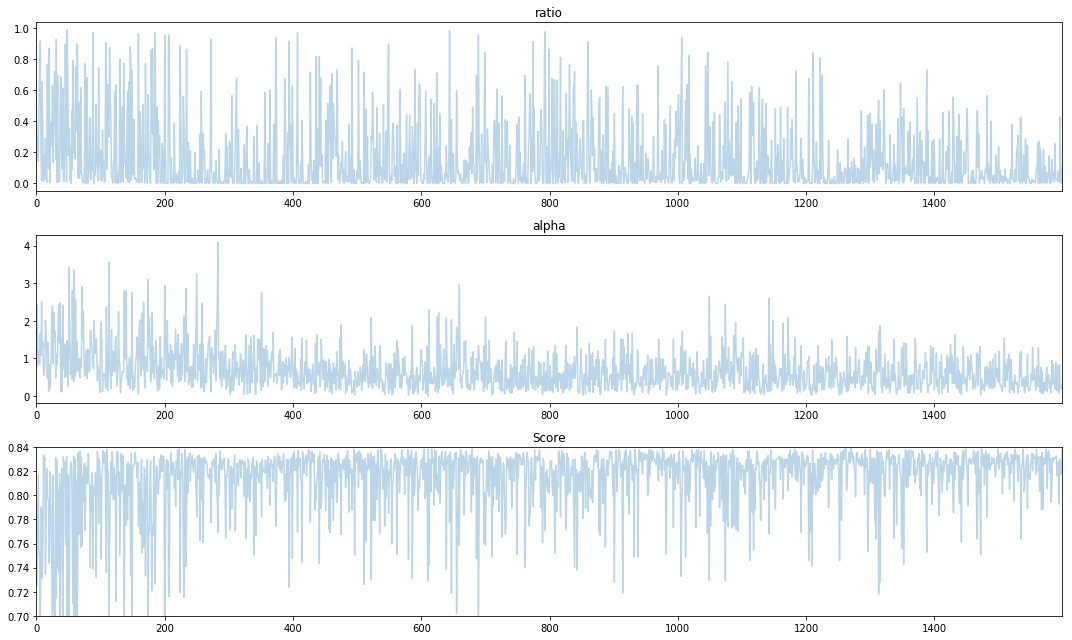

In [698]:
plt.figure(figsize=[15,9])
plt.subplot(3,1,1)
trials.ratio.plot(alpha=.3)
plt.title('ratio')
plt.subplot(3,1,2)
trials.alpha.plot(alpha=.3)
plt.title('alpha')
plt.subplot(3,1,3)
trials.score.plot(alpha=.3)
plt.ylim([.7,.84])
plt.title('Score')
plt.tight_layout()

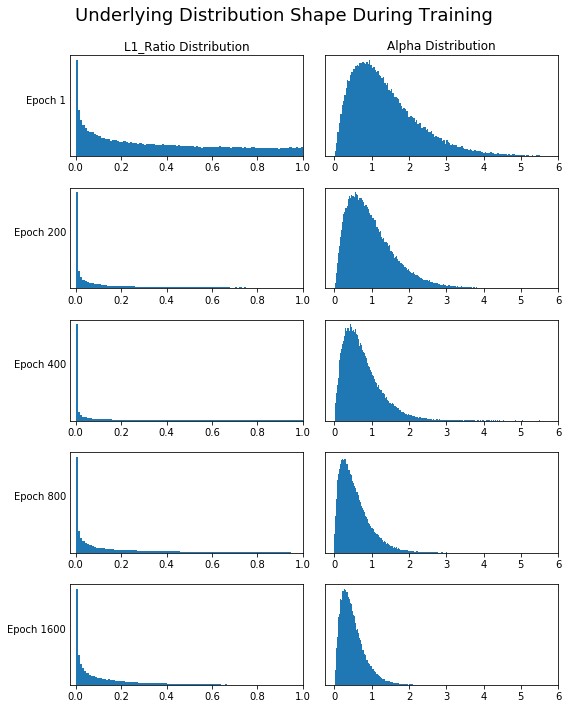

In [693]:
fig, axes = plt.subplots(5,2, figsize=[8,10])

def show_dist(a, b, c, d, row, subplots):
    _ = subplots[0].hist(np.random.beta(a, b, 100000), bins=100, density=True)
    if row==0:
        subplots[0].set_title('L1_Ratio Distribution')
    subplots[0].set_xlim([-.025,1])
    subplots[0].set_yticks([])
    subplots[0].set_ylabel('Epoch '+str(row+1), rotation=0, ha='right')

    _ = subplots[1].hist(np.random.gamma(c, 1./d, 100000), bins=250, density=True)
    if row==0:
        subplots[1].set_title('Alpha Distribution')
    subplots[1].set_xlim([-.25,6])
    subplots[1].set_yticks([])

n_rows = len(trials)
rows = [0]+[(n_rows // (2**i))-1 for i in [3,2,1,0]]
# rows= [0,399,799,1199,1599]
for i, row in enumerate(rows):
    show_dist(trials['a'].values[row], trials['b'].values[row],
              trials['c'].values[row], trials['d'].values[row],
              row, axes[i])
_ = plt.suptitle('Underlying Distribution Shape During Training', fontsize=18)
plt.tight_layout(rect=[0,0,1,.95])

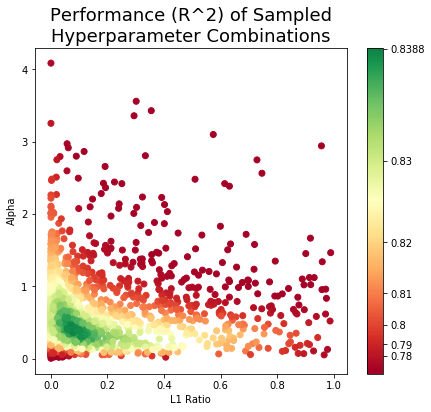

In [494]:
plt.figure(figsize=[7,6])

expon = 40

plt.scatter(trials.ratio, trials.alpha, c=trials.score**expon, cmap='RdYlGn')
plt.xlabel('L1 Ratio')
plt.ylabel('Alpha')

plt.title('Performance (R^2) of Sampled\nHyperparameter Combinations', fontsize=18)
cbar = plt.colorbar()
cbar.set_clim([.75**expon, maxim**expon])
values = [.78,.79,.8,.81,.82,.83,.8388]

cbar.set_ticks([v**expon for v in values])
cbar.set_ticklabels(values)

Text(0.25145999255336493, 1.080922631796189, 'Start')

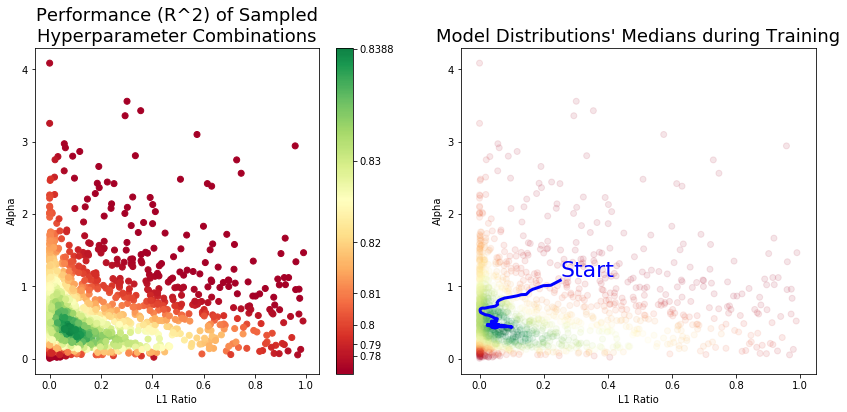

In [708]:
plt.figure(figsize=[14,6])
plt.subplot(1,2,1)
expon = 40

plt.scatter(trials.ratio, trials.alpha, c=trials.score**expon, cmap='RdYlGn')
plt.xlabel('L1 Ratio')
plt.ylabel('Alpha')

plt.title('Performance (R^2) of Sampled\nHyperparameter Combinations', fontsize=18)
cbar = plt.colorbar()
cbar.set_clim([.75**expon, maxim**expon])
values = [.78,.79,.8,.81,.82,.83,.8388]

cbar.set_ticks([v**expon for v in values])
cbar.set_ticklabels(values)

plt.subplot(1,2,2)
alphas = []
ratios = []
span = 64
for i in range(span,1600,int(span/4)):
    a = trials['a'].values[i-span:i+16].mean()
    b = trials['b'].values[i-span:i+16].mean()
    c = trials['c'].values[i-span:i+16].mean()
    d = trials['d'].values[i-span:i+16].mean()
    ratios.append(np.quantile(np.random.beta(a,b,10000),.5))
    alphas.append(np.quantile(np.random.gamma(c,1./d,10000),.5))    
    
plt.scatter(trials.ratio, trials.alpha, c=trials.score**expon, cmap='RdYlGn', alpha=.1)
plt.xlabel('L1 Ratio')
plt.ylabel('Alpha')
plt.title("Model Distributions' Medians during Training", fontsize=18)
# plt.xlim([0., .3])
# plt.ylim([0.24, 1.5])
plt.plot(ratios, alphas, linewidth=3, color='blue')

plt.text(ratios[0], alphas[0], 'Start',va='bottom', fontsize=22, color='blue')

## Use the weighted average of the top 5 results as our tuned hyperparameters

In [210]:
top_scorers = trials.sort_values('score', ascending=False)

In [211]:
top_scorers.head(10)[['alpha','ratio','score']]

,alpha,ratio,score
976,0.413986,0.069393,0.838860
1270,0.373823,0.075137,0.838853
1262,0.421758,0.069270,0.838809
1449,0.446501,0.073931,0.838734
1499,0.367499,0.075551,0.838723
222,0.370162,0.079834,0.838624
495,0.405227,0.088180,0.838543
604,0.474032,0.058239,0.838516
1473,0.356941,0.081067,0.838507
679,0.361333,0.063986,0.838447


In [212]:
n=5
tuned_alpha = np.average(top_scorers.alpha[:n], weights=top_scorers.score[:n])
tuned_ratio = np.average(top_scorers.ratio[:n], weights=top_scorers.score[:n])

In [417]:
print (tuned_alpha, tuned_ratio)

0.4047131657794746 0.07265640884587755


## Revisit how the tuned model compares to the models from the beginning on training data (before on the held-out test data)

In [421]:
print ("Linear Regression R^2: {:.3f}".format(cross_val_score(LinearRegression(), X_train, y_train, cv=10).mean()))
print ("(OLS has trouble when there are more features than samples, I believe)\n")


print ("Default Lasso R^2: {:.3f}".format(cross_val_score(Lasso(), X_train, y_train, cv=10).mean()))
print ("Default Ridge R^2: {:.3f}".format(cross_val_score(Ridge(), X_train, y_train, cv=10).mean()))
print ("Default Elastic Net R^2: {:.3f}".format(cross_val_score(ElasticNet(), X_train, y_train, cv=10).mean()))

lcv = LassoCV(cv=10).fit(X_train, y_train)
print ('LassoCV R^2: {:.3f}'.format(cross_val_score(Lasso(alpha=lcv.alpha_), X_train, y_train, cv=10).mean()))
rcv = RidgeCV(alphas=[.01,.03,.1,.3,1,3,10,30,100,300,1000]).fit(X_train, y_train)
print ('RidgeCV R^2: {:.3f}'.format(cross_val_score(Ridge(alpha=rcv.alpha_), X_train, y_train, cv=10).mean()))
tuned = ElasticNet(alpha=tuned_alpha, l1_ratio=tuned_ratio, max_iter=100000, tol=.00001)
print ("Tuned Elastic Net R^2:", cross_val_score(tuned, X_train, y_train, cv=10).mean())

Linear Regression R^2: -182.085
(OLS has trouble when there are more features than samples, I believe)

Default Lasso R^2: 0.699
Default Ridge R^2: 0.694
Default Elastic Net R^2: 0.749
LassoCV R^2: 0.771
RidgeCV R^2: 0.795
Tuned Elastic Net R^2: 0.804515255436888


## Now, see how the models do on the held-out test data

In [434]:
scores = {}
tuned.fit(X_train, y_train)
# scores['Linear'] = LinearRegression().fit(X_train, y_train).score(X_test, y_test)
scores['Lasso'] = Lasso().fit(X_train, y_train).score(X_test, y_test)
scores['Ridge'] = Ridge().fit(X_train, y_train).score(X_test, y_test)
scores['ElasticNet'] = ElasticNet().fit(X_train, y_train).score(X_test, y_test)

scores['LassoCV'] = lcv.score(X_test, y_test)
scores['RidgeCV'] = rcv.score(X_test, y_test)
scores['Tuned ElasticNet'] = tuned.score(X_test, y_test)



In [427]:
scores

{'Lasso': 0.6745935307428219,
 'Ridge': 0.6501540348422041,
 'Elastic Net': 0.7027244025785024,
 'LassoCV': 0.7541036338923892,
 'RidgeCV': 0.7695031763336939,
 'Tuned ElasticNet': 0.7773645631884343}

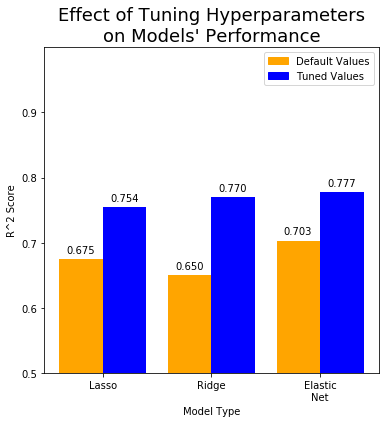

In [714]:
plt.figure(figsize=[6,6])
bar_width = .5
spacing = 1.25
plt.title("Effect of Tuning Hyperparameters\non Models' Performance", fontsize=18)


defaults = ['Lasso','Ridge','ElasticNet']
tuned_models = ['LassoCV','RidgeCV','Tuned ElasticNet']

plt.bar(x=np.arange(3)*spacing, height=[scores[m] for m in defaults],
        width=bar_width, color='orange')

plt.bar(x=np.arange(3)*spacing+bar_width, height=[scores[m] for m in tuned_models],
        width=bar_width, color='blue')


plt.ylim([.5,1])
plt.yticks(np.linspace(.5,.9,5))

for i, res in enumerate(defaults):
    x_coor = (i*spacing)-(bar_width/4.) - (bar_width*.085)
    resulting_score = '{:.3f}'.format(scores[res])
    plt.text(x_coor, scores[res]+.01, resulting_score)

for i, res in enumerate(tuned_models):
    x_coor = (i*spacing)+(3*bar_width/4.) - (bar_width*.085)
    resulting_score = '{:.3f}'.format(scores[res])
    plt.text(x_coor, scores[res]+.01, resulting_score)
    
plt.xticks(np.arange(3)*spacing+(bar_width/2.), ['Lasso', 'Ridge','Elastic\nNet'])
plt.xlabel('Model Type')
plt.ylabel('R^2 Score')
import matplotlib.patches as mpatches

untuned_patch = mpatches.Patch(color='orange', label='Default Values')
tuned_patch = mpatches.Patch(color='blue', label='Tuned Values')
_=plt.legend(handles=[untuned_patch, tuned_patch], loc=1)